In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
import forestplot as fp

In [2]:
# import data
#diffexp_df = pd.read_excel('diffexp_230621_CLEMENCE_ANALYSIS2B_2023-06-22_03-27-13.xlsx', sheet_name='diffexp')
diffexp_df = pd.read_excel('diffexp_newmodel.xlsx')
runkey_df = pd.read_excel('diffexp_230621_CLEMENCE_ANALYSIS2B_2023-06-22_03-27-13.xlsx', sheet_name='runkey')
lipidisease_tsv = '/Users/brendansu/PycharmProjects/DMEK_v2/lipidisease_output.tsv'
lipidisease_df = pd.read_table(lipidisease_tsv,sep='\t')

In [3]:
# maping control vs glaucoma
map = {
    "Control" : int(0),
    "Glaucoma" : int(1)
}

# mapping glaucoma vs dmek
dg_map = {
    "Glaucoma" : int(0),
    "DMEK": int(1)
}

# mapping control vs dmek
dc_map = {
    "Control" : int(0),
    "DMEK": int(1)
}

# mapping glaucoma + control vs dmek
dgc_map = {
    "Glaucoma" : int(0),
    "Control" : int(0),
    "DMEK": int(1)
}

# function to group patients by group membership
def grouper(value):
    value = str(value)
    return value.split(' ')[0].split('_')[0]

# map to binary group control vs glaucoma
def map_outcome(group):
    if not isinstance(group, str):
        return None
    for key in map.keys():
        if key in group:
            return int(map[key])
    return None

# map to binary group glaucoma vs dmek
def map_outcome_dg(group):
    if not isinstance(group, str):
        return None
    for key in dg_map.keys():
        if key in group:
            return int(dg_map[key])
    return None

# map to binary group control vs dmek
def map_outcome_dc(group):
    if not isinstance(group, str):
        return None
    for key in dc_map.keys():
        if key in group:
            return int(dc_map[key])
    return None

# map to binary group glaucoma + control vs dmek
def map_outcome_dgc(group):
    if not isinstance(group, str):
        return None
    for key in dgc_map.keys():
        if key in group:
            return int(dgc_map[key])
    return None

runkey_df['id.group'] = runkey_df['ID'].apply(grouper)

In [4]:
# define linear regression function
def linreg(name, map, runkey_df = runkey_df,pr=False):

    pval_name = name + '.pval'
    coef_name = name + '.coef'
    se_name = name + '.se'

    if map =='dg' :
        runkey_df['id.outcome'] = runkey_df['id.group'].apply(map_outcome_dg)
    elif map == 'dc':
        runkey_df['id.outcome'] = runkey_df['id.group'].apply(map_outcome_dc)
    elif map == 'dgc':
        runkey_df['id.outcome'] = runkey_df['id.group'].apply(map_outcome_dgc)
    runkey_df = runkey_df[runkey_df['id.outcome'].notna()]

    samples = runkey_df['runId'].tolist()
    column_names = [f'log10expr.{i}' for i in samples]
    column_names.insert(0,'id.name')
    X_df = diffexp_df[column_names]
    X_df = X_df.transpose()
    X = X_df.iloc[1:].to_numpy(dtype=float)
    y = runkey_df['id.outcome'].to_numpy(dtype=float)

    # First, add a constant to y outside the loop. This is for the intercept.
    y_with_const = sm.add_constant(y.reshape(-1, 1))

    results = {}
    for i in range(X.shape[1]):
        # Now, fit the model using X[:, i] as the independent variable and y_with_const as the dependent variable.
        # Notice we select the entire column for each feature in X with X[:, i].
        model = sm.OLS(X[:, i], y_with_const).fit()

        coef = model.params[1]  # Coefficient of the feature
        pval = model.pvalues[1]  # P-value for the feature
        se = model.bse[1]
        if i==0 and pr:
            print(f'Feature_{i}')
            print(model.summary())

        results[f"Feature_{i}"] = {f'{coef_name}': coef, f'{pval_name}': pval, f'{se_name}'+'l': coef-1.96*se, f'{se_name}'+'h': coef+1.96*se}

    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df['id.name'] = diffexp_df['id.name'].tolist()
    diffexp_df[coef_name] = results_df[coef_name].tolist()
    diffexp_df[pval_name] = results_df[pval_name].tolist()
    diffexp_df[se_name+'l'] = results_df[se_name+'l'].tolist()
    diffexp_df[se_name+'h'] = results_df[se_name+'h'].tolist()

In [5]:
# run linear reg on all 3 mappings
linreg(name='lm1.groupDG',map='dg',pr=True)

linreg(name='lm1.groupDC', map='dc')

linreg(name='lm1.groupDGC', map='dgc')

diffexp_df.to_excel('diffexp_newmodel.xlsx', index=False)
diffexp_df

Feature_0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     58.25
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           1.53e-06
Time:                        13:40:30   Log-Likelihood:                 4.7561
No. Observations:                  17   AIC:                            -5.512
Df Residuals:                      15   BIC:                            -3.846
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9850      0.074     81.31

,id.index,id.level,id.score1,id.score2,id.name,id.name2,id.description,id.formula,id.uniprot,id.type,...,lm1.groupDMEK.bh.pval,lm1.groupDG.se,lm1.groupDC.se,lm1.groupDGC.se,lm1.groupDG.sel,lm1.groupDG.seh,lm1.groupDC.sel,lm1.groupDC.seh,lm1.groupDGC.sel,lm1.groupDGC.seh
0,1,2.0,0.9949,0.9987,GELS_HUMAN,GELS_HUMAN;lvl2=3;lvl3=0,Gelsolin,C133H201N35O41,P06396,protein,...,4.852705e-08,[0.07360217 0.09596549],[0.05646701 0.08182847],[0.0443552 0.07422044],-0.920492,-0.544308,-1.015875,-0.695107,-0.953094,-0.662150
1,2,2.0,0.9990,0.9963,OPT_HUMAN,OPT_HUMAN;lvl2=6;lvl3=0,Opticin,C66H108N20O20,Q9UBM4,protein,...,4.852705e-08,[0.04999066 0.06517984],[0.04808651 0.06968397],[0.04143946 0.06934147],-0.576967,-0.321462,-0.819535,-0.546374,-0.727965,-0.456146
2,3,2.0,0.8290,0.9960,AC 16:3,AC 16:3;lvl2=1;lvl3=0,AC 16:3,NaN,NaN,lipid,...,2.463887e-07,[0.39759346 0.51839844],[0.13436278 0.19471016],[0.2598047 0.43473642],0.697539,2.729661,3.076877,3.840141,1.927850,3.632017
3,4,2.0,0.9927,0.9918,CATD_HUMAN,CATD_HUMAN;lvl2=7;lvl3=0,Cathepsin D,C42H64N8O16,P07339,protein,...,2.463887e-07,[0.08891267 0.11592794],[0.06524515 0.09454921],[0.05083454 0.08506246],-0.977419,-0.522981,-1.045062,-0.674429,-0.983867,-0.650422
4,5,2.0,0.9988,0.9984,TTHY_HUMAN,TTHY_HUMAN;lvl2=16;lvl3=0,Transthyretin,C109H163N31O34,P02766,protein,...,2.463887e-07,[0.07290774 0.09506006],[0.06488704 0.09403026],[0.05387664 0.09015286],-0.767303,-0.394668,-1.015363,-0.646764,-0.910511,-0.557112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,613,2.0,0.8700,0.0930,Linoleic Acid-Biotin,Linoleic Acid-Biotin;lvl2=1;lvl3=0,NaN,C28H48N4O3S,NaN,compound,...,9.762289e-01,[0.3029809 0.39503876],[0.20951683 0.30361873],[0.15678047 0.2623439 ],-0.326262,1.222290,-0.583975,0.606211,-0.333172,0.695216
613,614,2.0,0.9960,0.1000,4-Picoline,4-Picoline;lvl2=1;lvl3=0,NaN,C6H7N,NaN,compound,...,9.812712e-01,[0.33316479 0.43439374],[0.34621481 0.50171292],[0.24483298 0.40968394],-1.588983,0.113840,-0.996448,0.970266,-1.097814,0.508147
614,615,2.0,0.8050,0.0900,2-(4-Methoxybenzylidene)Quinuclidin-3-one,2-(4-Methoxybenzylidene)Quinuclidin-3-one;lvl2...,NaN,C15H17NO2,NaN,compound,...,9.857977e-01,[0.16023222 0.20891725],[0.12454489 0.18048269],[0.09321554 0.15597943],-0.583778,0.235178,-0.357410,0.350082,-0.375742,0.235697
615,616,2.0,0.9190,0.6260,NP-019811,NP-019811;lvl2=1;lvl3=0,NaN,C6H7NO2,NaN,compound,...,9.857977e-01,[0.13377014 0.17441493],[0.10714586 0.1552691 ],[0.08353026 0.13977286],-0.411210,0.272496,-0.307373,0.301282,-0.302788,0.245121


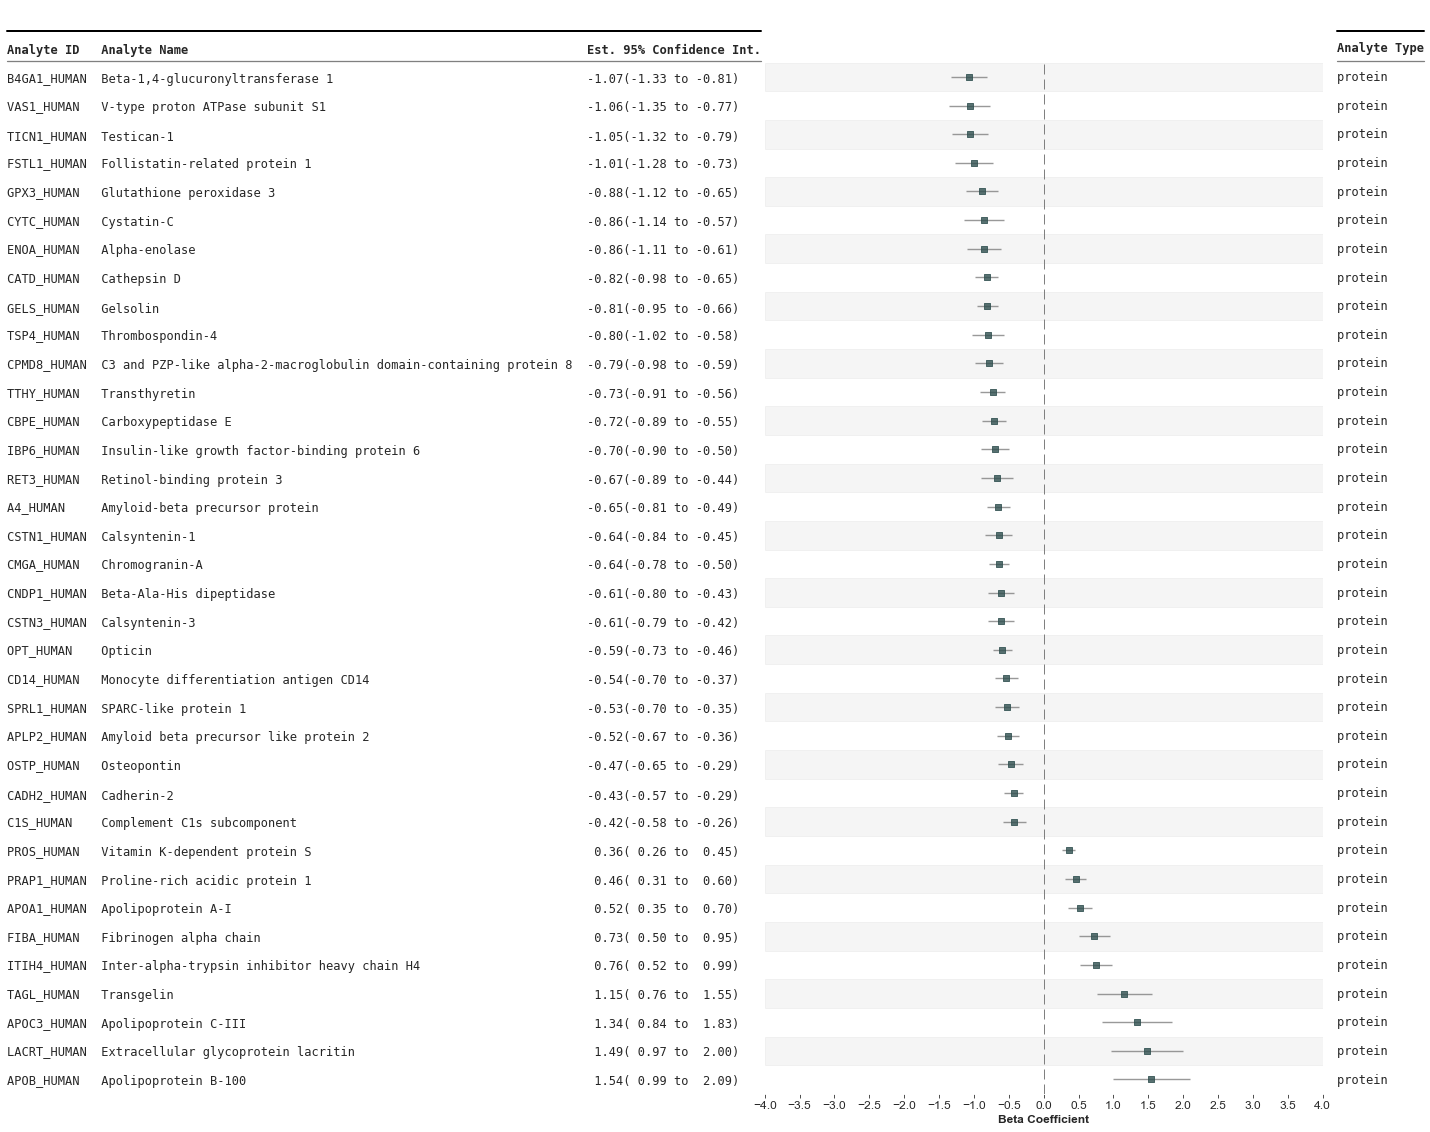

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# define forst plot
def forest(df, name):
    # Convert specific columns to string to avoid the AttributeError
    if 'id.name' in df.columns:
        df['id.name'] = df['id.name'].astype(str)
    if 'id.type' in df.columns:
        df['id.type'] = df['id.type'].astype(str)
    if 'id.description' in df.columns:
        df['id.description'] = df['id.description'].fillna('n/a').astype(str)

    # Assuming fp.forestplot is a function from a specific library
    # and this library is properly imported as fp
    fp.forestplot(df, ll='lm1.groupDGC.sel',
                  hl='lm1.groupDGC.seh',
                  estimate='lm1.groupDGC.coef',
                  varlabel='id.name',
                  xlabel='Beta Coefficient',
                  figsize=(10,len(df)/1.8),
                  rightannote=['id.type'],
                  right_annoteheaders=['Analyte Type'],
                  annote=['id.description','est_ci'],
                  annoteheaders=['Analyte Name',"Est. 95% Confidence Int."],
                  color_alt_rows=True,
                  xticks=np.arange(-4, 4.1, 0.5).flatten(),
                  table=True,
                 **{
                     "markersize": 35,  # adjust marker size
                     "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
                     "xlinecolor": "#808080",  # gray color for x-reference line
                     "xtick_size": 12,  # adjust x-ticker fontsize
                     'variable_header': 'Analyte ID',
                     'res': 1200
                    }
                  )
    ax = plt.gca()  # Get current axes
    ax.grid(False)  # Disable gridlines
    ax.set_facecolor('#FFFFFF')
    forest = plt.gcf()
    forest.savefig(f'forest_{name}',bbox_inches='tight')
    forest.show()

forest(diffexp_df[
           (diffexp_df['lm1.groupDMEK.bh.pval']<0.01)&
           (diffexp_df['lm1.groupDG.bh.pval']<0.01)&
           (diffexp_df['id.type']=='protein')
       ].sort_values('lm1.groupDGC.coef',ascending=True), 'protein')

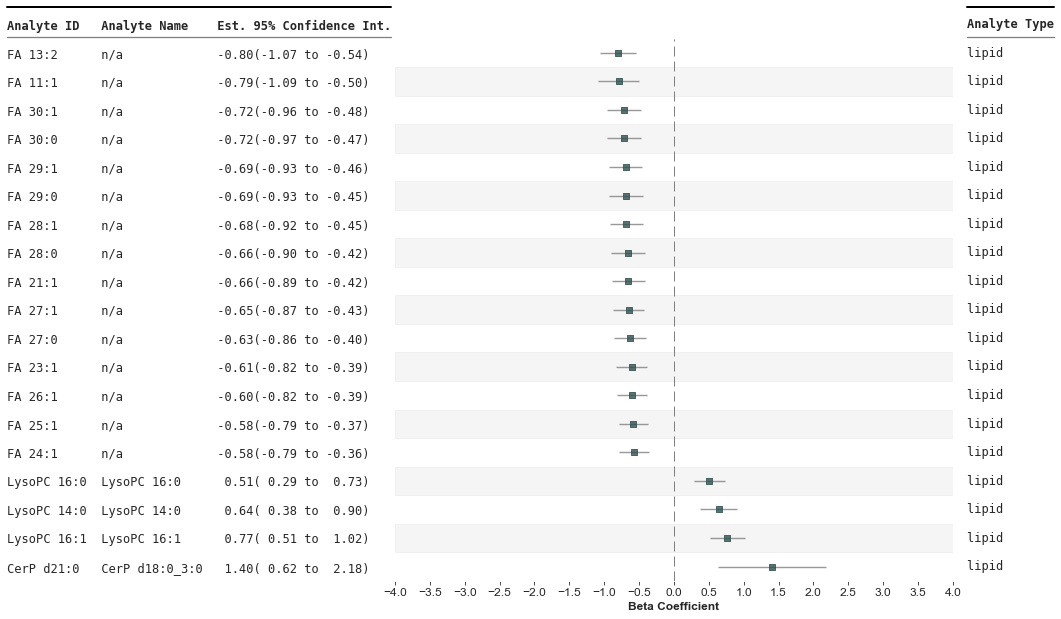

In [7]:
forest(diffexp_df[
           (diffexp_df['lm1.groupDMEK.bh.pval']<0.01)&
           (diffexp_df['lm1.groupDG.bh.pval']<0.01)&
           (diffexp_df['id.type']=='lipid')
       ].sort_values('lm1.groupDGC.coef',ascending=True), 'lipid')

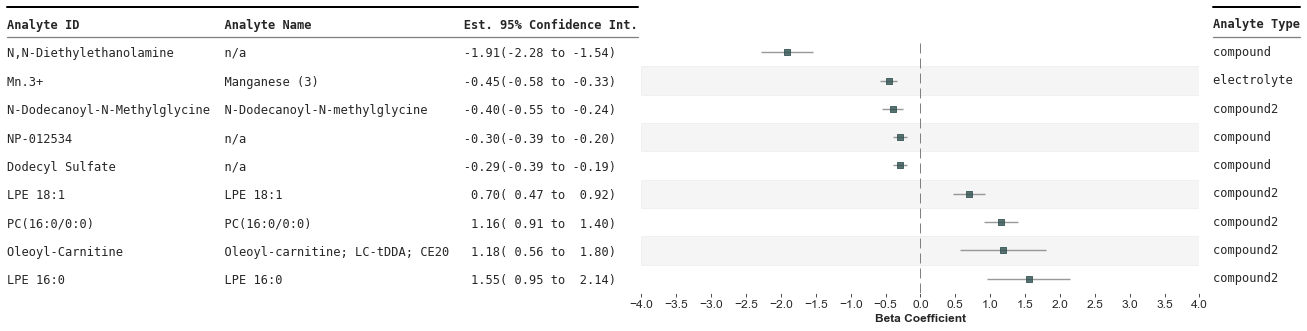

In [8]:
forest(diffexp_df[
           (diffexp_df['lm1.groupDMEK.bh.pval']<0.01)&
           (diffexp_df['lm1.groupDG.bh.pval']<0.01)&
           (diffexp_df['id.type']!='lipid')&
           (diffexp_df['id.type']!='protein')
       ].sort_values('lm1.groupDGC.coef',ascending=True), 'metabolite')

In [9]:
runkey_df['id.outcome'] = runkey_df['id.group'].apply(map_outcome)

runkey_df = runkey_df[runkey_df['id.outcome'].notna()]

samples = runkey_df['runId'].tolist()
column_names = [f'log10expr.{i}' for i in samples]
column_names.insert(0,'id.name')
X_df = diffexp_df[column_names]
X_df = X_df.transpose()
X = X_df.iloc[1:].to_numpy(dtype=float)
y = runkey_df['id.outcome'].to_numpy(dtype=float)
runkey_df['id.outcome'].tolist()

X_df.columns = X_df.iloc[0]
X_df = X_df[1:]
combined_df = X_df
combined_df['group'] = runkey_df['id.outcome'].tolist()
combined_df.reset_index(drop=True, inplace=True)
collist = combined_df.columns.tolist()
i = 0
for col in collist:
    if pd.isnull(col):
        collist[i] = f'EMPTY{i}'
        print('found')
    i+= 1
collist
combined_df.columns=collist

found
found
found


In [10]:
# Kolmogorov-Smirnov test
g_df = combined_df[combined_df['group'] == 1]
c_df = combined_df[combined_df['group'] == 0]
ks_pval = []
for col in combined_df.columns[:-1]:
    print(g_df[col].to_numpy())
    print(col)
    results = stats.ks_2samp(g_df[col],c_df[col])
    ks_pval.append([col, results[0], results[1]])
ks_df = pd.DataFrame(ks_pval)
ks_df[ks_df[2]<0.01/617]

[6.248 5.886 5.722 6.063 6.127 5.862 5.987]
GELS_HUMAN
[6.409 6.188 6.012 6.12 6.225 6.159 6.194]
OPT_HUMAN
[2.988 3.131 6.017 5.297 2.095 5.51 5.51]
AC 16:3
[6.168 5.621 5.612 5.936 6.024 5.746 5.745]
CATD_HUMAN
[7.284 6.836 6.861 7.058 7.18 6.794 6.919]
TTHY_HUMAN
[10.18 9.93 9.717 9.955 9.875 9.925 9.718]
N,N-Diethylethanolamine
[7.801 8.369 8.352 8.44 7.971 8.164 8.246]
PC(16:0/0:0)
[6.139 5.644 5.686 5.814 5.823 5.806 5.868]
CBPE_HUMAN
[7.312 7.293 6.709 6.474 7.193 6.587 6.79]
SP d17:0
[5.625 5.426 5.144 5.056 5.525 5.257 5.217]
B4GA1_HUMAN
[6.061 6.219 5.947 6.225 6.248 6.001 6.178]
CMGA_HUMAN
[4.775 5.128 5.603 5.033 4.681 5.41 4.884]
TAGL_HUMAN
[6.215 6.193 6.414 6.388 6.19 6.301 6.291]
PROS_HUMAN
[5.136 5.928 5.799 5.948 4.931 5.623 5.568]
APOC3_HUMAN
[6.518 6.11 6.049 5.989 6.411 6.047 6.191]
TICN1_HUMAN
[6.161 6.139 5.917 5.895 6.064 5.656 6.133]
CFAI_HUMAN
[7.082 6.368 6.58 6.78 7.107 6.723 6.619]
IBP6_HUMAN
[5.712 5.298 5.014 5.309 5.781 5.349 5.293]
CPMD8_HUMAN
[8.06 8.3

,0,1,2


In [12]:
combined_df.to_excel('combined_df.xlsx',index=False)